<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For Background on the Dataset see: https://cps.ipums.org/cps-action/variables/group

### **Clone Library**

In [31]:
!git clone https://github.com/pharringtonp19/business-analytics.git

Cloning into 'business-analytics'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (549/549), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 932 (delta 405), reused 424 (delta 326), pack-reused 383 (from 1)
Receiving objects: 100% (932/932), 17.77 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (533/533), done.


### **Import Packages**

In [32]:
import jax
import jax.numpy as jnp
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf

### **Read In Data Set**

In [37]:
df = pd.read_csv('/content/business-analytics/datasets/cps_00009.csv.gz', compression="gzip")
df['INCTOT'].replace(999999999, np.nan, inplace=True)

<ipython-input-37-210537a456b6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['INCTOT'].replace(999999999, np.nan, inplace=True)


In [38]:
df.head()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,PERNUM,CPSIDV,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,VETSTAT,FTOTVAL,INCTOT
0,2024,6,3,20230200357800,1,601.57,1,202302003578011,20230200357801,601.57,85,2,100,1,1,32206,8565.0
1,2024,6,3,20230200357800,1,601.57,2,202302003578021,20230200357802,601.57,85,1,100,1,2,32206,23641.0
2,2024,6,3,20230200357800,1,601.57,3,202302003578031,20230200357803,1312.04,15,2,100,6,0,0,0.0
3,2024,7,3,20230100363800,1,1559.99,1,202301003638011,20230100363801,1559.99,53,2,100,1,1,50838,10801.0
4,2024,7,3,20230100363800,1,1559.99,2,202301003638021,20230100363802,1559.99,52,1,100,1,1,50838,40037.0


In [43]:
df.shape

(144265, 17)

### **Plot**

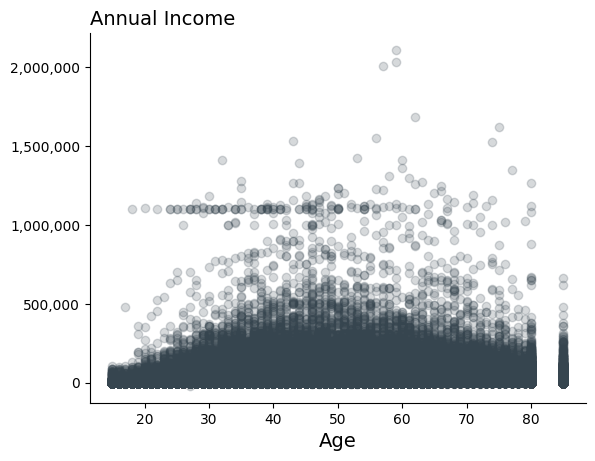

In [42]:
plt.scatter(df['AGE'], df['INCTOT'], color="#36454F", alpha=0.2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('Age', size=14)
plt.title('Annual Income', size=14, loc='left')
plt.show()

In [ ]:
def affine_f(x, params):
  return params[0] + x*params[1]

def random_line(key):
  xs = jnp.linspace(0, 4500, 10)
  params = jax.random.normal(key, shape=(2,))*500
  ys = affine_f(xs, params)
  return xs, ys


plt.scatter(df['size'], df['price'], color="#36454F")

key = jax.random.PRNGKey(0)
for i in range(10):
  key, _ = jax.random.split(key)
  plt.plot(*random_line(key))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('Size', size=14)
plt.title('Price', size=14, loc='left')
plt.show()

In [ ]:
def affine_f(x, params):
    return params[0] + x * params[1]

def random_line(key):
    xs = jnp.linspace(0, 4500, 10)
    params = jax.random.normal(key, shape=(2,)) * 500
    ys = affine_f(xs, params)
    return xs, ys, params

# Generate main plot and parameter space subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of size vs. price
ax1.scatter(df['size'], df['price'], color="#36454F")
key = jax.random.PRNGKey(0)

params_list = []
for i in range(10):
    key, _ = jax.random.split(key)
    xs, ys, params = random_line(key)
    ax1.plot(xs, ys, alpha=0.7)
    params_list.append(params)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_xlabel('Size', size=14)
ax1.set_title('Price', size=14, loc='left')


for p in params_list:
  plt.scatter(p[0], p[1])
ax2.set_xlabel('Intercept Parameter', size=14)
ax2.set_title('Slope Parameter', size=14, loc='left')
ax2.axhline(0, linestyle='--', color='black')
ax2.axvline(0, linestyle='--', color='black')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Define the functions
def affine_f(x, params):
    return params[0] + x * params[1]

# Define a mean squared error loss function
def loss_function(params, xs, ys_true):
    ys_pred = affine_f(xs, params)
    return jnp.mean((ys_true - ys_pred) ** 2)

# Create data points from your dataset
xs = jnp.array(df['size'].values)
ys_true = jnp.array(df['price'].values)

# Define parameter ranges and create a grid
intercepts = jnp.linspace(0, 2000, 50)
slopes = jnp.linspace(-1000, 1000, 50)
intercepts_grid, slopes_grid = jnp.meshgrid(intercepts, slopes)

# Vectorize the loss computation over the grid
params_grid = jnp.stack([intercepts_grid.ravel(), slopes_grid.ravel()], axis=-1)
loss_values = jax.vmap(lambda params: loss_function(params, xs, ys_true))(params_grid)
loss_values = loss_values.reshape(intercepts_grid.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(intercepts_grid, slopes_grid, loss_values, cmap='viridis', edgecolor='none')

# Customize the plot
ax.set_xlabel("Intercept")
ax.set_ylabel("Slope")
ax.set_zlabel("Loss (MSE)")
ax.view_init(elev=10, azim=120)  # Adjust these values as needed

plt.show()

In [ ]:
eqn = smf.ols('price ~ size', data = df)
results = eqn.fit()
results.params

### **Fitted Values**

In [ ]:
plt.scatter(df['size'], df['price'], color="#36454F")
plt.scatter(df['size'], results.fittedvalues)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_xlabel('Size', size=14)
ax.set_title('Price', size=14, loc='left')
plt.show()


### **Residuals**

In [ ]:
plt.scatter(df['size'], results.resid)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_xlabel('Size', size=14)
ax.set_title('Residuals', size=14, loc='left')
plt.show()

In [ ]:
results.summary()